$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
.

<img src="../3600.jpg" width=500 />

# Tutorial 5: Attention

## Todays Agenda
---
- recap on sequnce modeling
- Encoder Decoder and Latent space
- Attention mechanisms
    - dot product attention
    - Additive attention
    - self attention
- Implementing attention
- machine translation
    - Encoder Decoder with GRU
    - BLEU score
    - Encoder Decoder with self attention for Alignment
### second part
- Transformers architecture
- Positinal encoding
- Inference with transformer
- introduction to VIT

## imports
---

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")


# pytorch
import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets as datasets
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reminders and recaps
---

Last tutorial we learned about RNNs:

with 2 layer $l$:

<center><img src="resources/rnn_layered.png" width="1100" /></center>

Where, for each layer $l\geq 0$ ($l_0 is input$) and "time" $t > 0$:

$$
\begin{align}
\vec{h}_t^l &= \varphi_1\left( \mat{W}_{hh}^l \vec{h}_{t-1}^l + \mat{W}_{xh}^l \vec{x}_t^{l-1} + \vec{b}_h^l\right) \\
\vec{x}_t^l &= \varphi_2\left(\mat{W}_{hy}^l\vec{h}_t^l + \vec{b}_x^l \right).
\end{align}
$$


and we remember, that with long sequnce as input, we need to deal with the problem of vanishing/exploading gradients.<br>
that is why, we presented LSTM and GRU cells:

<center><img src="resources/Network-Structure-of-RNN-LSTM-and-GRU.png" width="1000" /></center>

as for the GRU:

- **reset gate**:
$$ R_t = \sigma(X_tW_{xr} + H_{t-1}W_{hr} +b_r) \in \mathbb{R}^{n \times h}$$
- **update gate**:
$$ Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} +b_z) \in \mathbb{R}^{n \times h} $$

- **candidate hidden state**: 
 $$ \tilde{H}_{t} = \text{tanh}\left(X_t W_{xh} + (R_t \odot H_{t-1})W_{hh} \right) + b_h$$
- **hidden state**:
$$ H_t = Z_t \odot H_{t-1} +(1-Z_t) \odot \tilde{H}_t. $$

The main idea is to have "soft-gates" ($\vec{r}_t$ and $\vec{z}_t$) that control how much of the previous state ($\vec{h}_{t-1}$) affects the next state $\vec{h}_t$ relative to the proposed next state $\tilde{\vec{h}}_{t}$.

and of course, we learned Bidirectional RNN:
<center><img src="resources/bi.png" width="900" /></center>

that for some tasks, we can aggregate hidden state from both begining and end of the sentence, and have a better idea of the real context we need to keep in $\vec{h}_{t}$ (this does not effect the vanishing gradients)

All of this improvments still leave us with some issues.

### 1. Long inputs

we saw that with CNNs, when we want a large receptive field, we need to use deeper models.
FHD images (1080p) are 1920 x 1080 , 4K (2160p) = 3840 x 2160 and for that sizes, features across the image is hard to learn, but resnet do a [pretty good job](https://gist.github.com/samson-wang/a6073c18f2adf16e0ab5fb95b53db3e6). <br>

in NLP however, RNN based models can deal with longer inputs sequnces when we use memory based cells, yet the sequnces remain couple of dozens of words.
that means that for tasks like sentiment analysis, we would be able to read a ~100 words review. but if we want to read a book, or a wikipedia page, we will have vanishing/exploading gradients interfere, even with smarter BPTT.


### 2. blanks
as a hole, the RNN model help us with seq2seq or seq2one. but we didn't talk about what happen if we want to predict a word in the middle, such task from elementry school, like **"i am ___ home"** <br>
this task might be very complex and can use bidirectional-RNN, yet when we want to predict more then one word, and when the deq is diffrent lenght from **\<BOS>** and **\<EOS>**, we might have a problem.


### 3. long-term dependencies
one might say that we solved that with the memory based RNNs, yet soon we're going to talk about encoder-decoder models, and if you think of it, the hidden state need to encode the meaning behind the current input, as well as the dependencies in the sentence in order to propogate gradients wisely. <br>
when we have long-term dependencies, more of the hidden state need learn the dependencies and less for understanding the meaning. here the problem is adversery while we have 2 tasks for one learning model.

We would like to have some sort of mechanism that deals with this problems<br>
this mechanism actually exist and and called **Attention mechanism**<br>

but before we dive deep into it, let's understand some other concept called **Encoder** and **Decoder**

## Encoder-Decoder
---

To rethink of the 3rd problem, let's talk a bit about what is that hidden state $h_t$.<br>

We can encode the input vector into some latent space.<br>

last tutorial we already saw a similar idea using the embeding layer.

Now if we want to encode all the input (sequence, image...) into some **latent space**.

**latent space**, also known as a latent feature space or **embedding space**, is an embedding of a set of items within a manifold in which items which resemble each other more closely are positioned closer to one another in the latent space

so if in the embeding we learned for words token, the manifold was $\mathcal{M}: \mathcal{R}_N -> \mathcal{R}^E$ where N is input space and $E$ is the embeding dimention,<br>
now, we would like to use latent space to a manifold $\mathcal{M}: \mathcal{R}^{Sec} -> \mathcal{R}^{E_2}$ where $\mathcal{R}^{Sec}$ represent any input (in NLP, think of it as we have **max len** of input, so `Sec` would be from the dim $N^{max len}$)

note the diffrence, now we need to learn a mapping, not from $R^1$ but the latent space should map a huge input space, therfore should typically be bigger as well

<center><img src="resources/ed1.PNG" width="900" /></center>

<center><img src="resources/edSEG.png" width="900" /></center>

<center><img src="resources/edlstm.png" width="900" /></center>



# Attention
---

originaly presented by [Bahdanau](https://arxiv.org/pdf/1409.0473.pdf),

### What is Attention?

The attention mechanism describes a (sort of) new type of layers for DNN's, especially in sequence tasks but not only.<br>

You can find a lot of definitions, but we're going to use it in the notion of "the decoder learn on what part of the input to focus (pay attention to)"<br>

for some reason, attention is defined with SQL notation:

- **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.

- **Keys**: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.

- **Values**: For each input element, we also have a value vector. This feature vector is the one we want to average over.

- **Score function**: To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$. The score function takes the query and a key as input, and output the relecance score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.


there is another definition of `soft attention` and `hard attention`... now we will do some math, and it's a bit confusing so try to keep up

we will use to notation of
- $n$ **key-value** pairs: $\left\{\left(\vec{k}_i, \vec{v}_i\right)\right\}_{i=1}^{n}$, where $\vec{k}_i\in\set{R}^{d_k}$, $\vec{v}_i\in\set{R}^{d_v}$
- A **query**, $\vec{q} \in\set{R}^{d_q}$ (the input)
- **score** / **similarity** (sometimes **energy**) function between keys and queries, $f_{attn}: \set{R}^{d_k}\times \set{R}^{d_q} \mapsto \set{R}$
- **a** will denote Attention score

basic attention, defined as we take this score function $f_{attn}$,between the **query** and each **key**, for each key.

$$
b_i = f_{attn}(\vec{k}_i, \vec{q}) \in \mathbb{R}, \vec{b} \in \mathbb{R}^n
$$


we compute the **attention weights** $a_i$ as:

$$
\vec{a} = Softmax(\vec{b})\\
\vec{a_i} = \frac{exp(f_{attn}(\vec{k}_i, \vec{q}))}{\sum_j{exp(f_{attn}(\vec{k}_j, \vec{q}))}}\\
$$


`soft attention` output is
$$
\vec{y} = \sum_{i=1}^{n} a_i \vec{v}_i\ \in \set{R}^{d_v},
$$

 `hard attention` output is

$$
\vec{y} \sim \mathrm{Multinoulli}\left(\vec{a}; \left\{\vec{v}_i\right\}_{i=1}^{n}\right)
$$


Now there are many types of score functions $f_{attn}$.

### 1. Scaled Dot Product Attention

One basic type of attention mechanism uses a simple **dot product** as the similarity function.

Widely-used by models based on the **Transformer** architecture, we're going to focus on it later on...

Assume $d_k=d_q=d$

$$
f_{attn}(\vec{k},\vec{q})= \frac{\vectr{k}\vec{q}}{\sqrt{d}}.
$$

Why scale by $\sqrt{d}$ ?

It's the factor at which the dot-product grows due to the dimensionality. E.g.,

$$
\norm{\vec{1}_d}_2 = \norm{[1,\dots,1]\Tr}_2 = \sqrt{d\cdot 1^2} =\sqrt{d}.
$$

This helps keep the softmax values from becoming very small when the dimension is large, and therefore helps prevent tiny gradients.

Let's now deal with $m$ queries simultaneously by stacking them as rows in a matrix $\mat{Q} \in \set{R}^{m\times d}$.

Similarly, we'll stack the keys and values as rows in their own matrices, $\mat{K}\in\set{R}^{n\times d}$, $\mat{V}\in\set{R}^{n\times d_v}$.

Then we can compute the attention weights for all queries in parallel:

$$
\begin{align}
\mat{B} &= \frac{1}{\sqrt{d}} \mat{Q}\mattr{K}  \ \in\set{R}^{m\times n} \\
\mat{A} &= softmax({\frac{\mat{Q}\mattr{K}}{\sqrt{d}}}) \in\set{R}^{m\times n} \\
\mat{Y} &= \mat{A}\mat{V} \ \in\set{R}^{m\times d_v}.
\end{align}
$$

Note that the softmax is applied per-row, and so each row $i$ of $\mat{A}$ contains the attention weights for the $i$th query.

Also notice that in this formulation, we **input a sequence** of $m$ queries and get an **output sequence** of $m$ weighed values.

<center><img src="resources/dotattn.PNG" width="400" /></center>

`mask` is optional for specific inputs, as for some tasks, we don't want to use the same index for learning (if we want to predict the missing word for instance) 


In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [4]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[-0.8811,  0.1282],
        [-0.2135,  1.0258],
        [-0.9106, -2.3857]])
K
 tensor([[-1.0584, -0.9490],
        [ 0.7700, -1.2492],
        [ 1.7036,  0.3881]])
V
 tensor([[ 0.7242,  1.4271],
        [-1.6837,  0.0382],
        [-1.9125, -0.3519]])
Values
 tensor([[-0.1232,  0.9039],
        [-1.0834,  0.2505],
        [-0.1114,  0.9421]])
Attention
 tensor([[0.6607, 0.2058, 0.1334],
        [0.2986, 0.1823, 0.5191],
        [0.6541, 0.3344, 0.0116]])


### 2. Multiplicative attention

now assime Assume $d_k \ne d_q$

we can preform something similar to before, as 
$$
f_{attn}(\vec{k},\vec{q})= {\vectr{k}\vec{W}\vec{q}}; W \in \mathcal{R}^{d_k x d_q}
$$

note that in that case we just add one learnable layer that learn the relation between the keys and queries

### 3. Additive attention

Another common type of attention mechanism uses an MLP to **learn** the similarity function $e(\vec{k},\vec{q})$.

In this type of attention, the similarity function is 

$$
f_{attn}(\vec{k},\vec{q}) = \vectr{w} \tanh(\mat{W}_k\vec{k} + \mat{W}_q\vec{q}),
$$

where $\mat{W}_k\in\set{R}^{h\times d_k}$, $\mat{W}_q\in\set{R}^{h\times d_q}$ and $\vec{w}\in\set{R}^{h}$ are trainable parameters.

- Notice that we're adding projected versions of the key and query and applying a 2-layer MLP.
- Both projections and the output layer are trainable.

**This Attention mechanisem is less in use, thus we're not going to focus on the visuallization and implementation**.
if you do want to implement it, [here is an example](https://sigmoidal.io/implementing-additive-attention-in-pytorch/)

## Self Attention
---

Self-attention refers to applying attention on a **single sequence**  $\left\{\vec{x}_i\right\}_{i=1}^{n}$ of elements.

The keys, values and queries are Computed from them with **learned** linear projections, i.e.
$$
\begin{align*}
\vec{q}_{i} &= \mat{W}_{xq}\vec{x}_{i} &
\vec{k}_{i} &= \mat{W}_{xk}\vec{x}_{i} &
\vec{v}_{i} &= \mat{W}_{xv}\vec{x}_{i} 
\end{align*}
$$
This is what Transformer models do for Seq2Seq, instead of using RNNs.

For example, the following image depicts dot product self-attention transforming the sequence $\left\{\vec{x}_i\right\}_{i=1}^{n}$ into the sequence $\left\{\vec{y}_i\right\}_{i=1}^{n}$.

<center><img src="resources/self_attn_transformer.svg" width=900></center>

## Sequence-to-Sequence Machine Translation
---

In this part we'll translate text from German to English.

The general approach using RNNs is to design a Sequence-to-sequence (**Seq2Seq**) Encoder-Decoder architecture:

<center><img src="resources/seq2seq1.png" width="1100" /></center>

- The encoder processes the source sequence
- The final encoder hidden state represents the entire source sequence
- This representation is passed to the decoder as it's initial hidden state
- During training the decoder is fed with the target sequence
- Both parts are trained together, end to end

We'll implement this idea roughly based on [Sutskever et al. (2014)](https://arxiv.org/abs/1409.3215), then we're going to add attention

### Dataset

We'll use the [Multi30K](https://www.statmt.org/wmt16/multimodal-task.html) Multimodal Dataset, which contains 30K images and sentences describing them in both German and English. We'll only use the textual data.

The `torchtext` package provides us with a convenient way to load our dataset.

In [5]:
from torchtext.datasets import Multi30k
from torchtext.data import Field

# Common args for field objects
field_args = dict(tokenize='spacy',
                  init_token='<sos>',
                  eos_token='<eos>',
                  include_lengths=True,
                  lower=True) 

# Field for processing German source
src_field = Field(tokenizer_language="de_core_news_sm", **field_args)

# Field for processing English target
tgt_field = Field(tokenizer_language="en_core_web_sm", **field_args)

In [6]:
ds_train, ds_valid, ds_test = Multi30k.splits(
    root=data_dir, exts=('.de', '.en'), fields=(src_field, tgt_field)
)

VOCAB_MIN_FREQ = 2 # ignore very rare words to decrease vocab size
src_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)
tgt_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)

In [7]:
print('#train samples: ', len(ds_train))
print('#valid samples: ', len(ds_valid))
print('#test  samples: ', len(ds_test))

#train samples:  29000
#valid samples:  1014
#test  samples:  1000


In [8]:
V_src = len(src_field.vocab)
print(f'source vocab size: {V_src}')

V_tgt = len(tgt_field.vocab)
print(f'target vocab size: {V_tgt}')

source vocab size: 7854
target vocab size: 5893


Let's look at some random sample

In [9]:
import random
for _ in range(5):
    i = random.randrange(len(ds_train))
    example = ds_train[i]
    src = str.join(" ", example.src)
    tgt = str.join(" ", example.trg)
    print(f'sample #{i:05d}:\n\tDE: {src}\n\tEN: {tgt}')

sample #03050:
	DE: eine bigband übt in einer kirche .
	EN: a orchestra band practices in a church .
sample #25742:
	DE: ein ungepflegter blonder mann spielt gitarre .
	EN: dirty blond man with tattoos is playing a guitar .
sample #09181:
	DE: drei frauen klettern leicht bekleidet auf einen drahtturm .
	EN: three women are climbing a wire tower while wearing little clothing .
sample #17577:
	DE: drei personen in bodies sind am boden und scheinen zu schreien .
	EN: three people in bodysuits are on the ground and appear to be screaming .
sample #06588:
	DE: junger erwachsener in grünem hemd mit rotem haar schreibt auf einem blatt papier .
	EN: young adult in a green shirt with red - hair writing on a piece of paper .


Let's check the top 20 words in english and german and the numbers assigned for known tokens

In [10]:
topn = 20
print(f'DE top{topn}: {src_field.vocab.itos[0:topn]}\n')
print(f'EN top{topn}: {tgt_field.vocab.itos[0:topn]}\n')



UNK_TOKEN = tgt_field.vocab.stoi['<unk>']
PAD_TOKEN = tgt_field.vocab.stoi['<pad>']
print(f'<unk>={UNK_TOKEN}, <pad>={PAD_TOKEN}')

DE top20: ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',', 'und', 'mit', 'auf', 'mann', 'einer', 'der', 'frau', 'die', 'zwei', 'einen']

EN top20: ['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'woman', ',', 'two', 'are', 'to', 'people']

<unk>=0, <pad>=1


In [11]:
from torchtext.data import BucketIterator

BATCH_SIZE = 4
dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size = BATCH_SIZE)

In [12]:
# dataloader returns a Batch object with .src and .trg attributes
b0 = next(iter(dl_train))

# The .src/.trg attributes contain tuples of sequences and their lengths
# Get batches of sequences 
x0, x0_len = b0.src
y0, y0_len =  b0.trg

print('x0 (S1, B):\n', x0, x0.shape)
print('x0_len (B,):\n', x0_len, x0_len.shape)
print('y0 (S2, B)):\n', y0, y0.shape)
print('y0_len: (B,)\n', y0_len, y0_len.shape)

x0 (S1, B):
 tensor([[   2,    2,    2,    2],
        [   5,   15,   15,    5],
        [  13, 1692,   32,   66],
        [  11,   32,   69,   25],
        [ 192,  472,   42,  512],
        [ 156,    8,   17, 1290],
        [  20,  494,  557,   19],
        [ 682,   11,    4, 1052],
        [  44,   24,    3,  154],
        [1445,  291,    1,    4],
        [  10,    4,    1,    3],
        [ 184,    3,    1,    1],
        [   5,    1,    1,    1],
        [ 286,    1,    1,    1],
        [   4,    1,    1,    1],
        [   3,    1,    1,    1]]) torch.Size([16, 4])
x0_len (B,):
 tensor([16, 12,  9, 11]) torch.Size([4])
y0 (S2, B)):
 tensor([[   2,    2,    2,    2],
        [  46,    7,    7,    4],
        [   9,   61,   35,   53],
        [ 273,   11,   10,   33],
        [  57,   25,  819,   10],
        [   6,   35,   76,  610],
        [   7,   10,    7,   40],
        [1171,  798,  379,    4],
        [  12,    4,    5,  807],
        [   4,  409,    3,  133],
        [ 159

### Model

Our `encoder` will start very simple. 
- Embed each source-language token in the sequence into a dense vector representation
- Feed the sequence through an RNN (i like GRU, so we would use 2-layers GRU)
- Output the final hidden states from each layer

Note that we also return the intermediate hidden states from the last layer. We'll need these later.

In [13]:
import torch.nn as nn

class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Encoder has no output layer; we just return hidden states.
        
    def forward(self, x, **kw):
        # x shape: (S, B) Note batch dim is not first!
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # GRU first  output: output of each token (of the last layer) (S, B, H)
        # GRU second output: last hidden state from each layer (L, B, H)
        y, ht = self.rnn(embedded)
        return y, ht

sainity check

In [14]:
EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
y, ht = enc(x0)
print(f'y (S1, B, H): {y.shape}')
print(f'ht (L, B, H): {ht.shape}')

y (S1, B, H): torch.Size([16, 4, 64])
ht (L, B, H): torch.Size([2, 4, 64])


Note again that the output dim is [x,btz,hidden], where x changes?

that's because of the bucket iterator that each time aligned to the maximum lenth input

Now for the `decoder`. We need to:
- Embed target-language tokens
- Apply RNN to the sequence, with initial hidden state from encoder
- Output is projection of intermediate hidden states from last layer to target-language tokens


In [15]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Output layer, note the output dimension!
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, context, **kw):
        # x shape: (S, B) the target-language sequence
        # context: (L, B, H) the last hidden state from the encoder
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Note initial hidden state is the input context vector
        # h:  all out states from last layer (S, B, H)
        # ht: last hidden state from each layer (L, B, H)
        y, ht = self.rnn(embedded, context)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(y)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

Test the decoder with the corresponding batch of English sentences:

In [16]:
dec = Seq2SeqDecoder(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
yhat, _ = dec(y0, ht) # note possibly different S
print(f'yhat (S2, B, V_tgt): {yhat.shape}')

yhat (S2, B, V_tgt): torch.Size([21, 4, 5893])


Next, we'll implement a `Seq2Seq` class to handle the combined forward pass through both the encoder and decoder.

We saw that we need to input the target sequence to the decoder.
That's fine for training.
But what do we do for inference, when we obviously don't know the target sequence?

During the forward pass, we'll take a source and target sequence and:
- **source**: Forward the source sequence through the encoder, obtaining the final hidden state.
- **target**: For the decoder, we'll either do:
    - **Teacher forcing**: Feed the decoder tokens from the target sequence one by one.
    - **Greedy prediction**: Use the decoder's output to predict the most likely next token, and feed it.

The greedy prediction approach is what we'll use for inference. For training we'll use **both**.

Teacher forcing:
<center><img src="resources/seq2seq.svg" width="1100"></center>

Greedy prediction:
<center><img src="resources/seq2seq_predict.svg" width="1100"></center>


Note that obviously in both cases the target sequence is still used to compute the loss.

Teacher forcing can speed up training, but it can hurt generalization. We'll take a probabilistic approach:
- Use teacher forcing with some probability $p_\mathrm{tf}$.
- Start $p_\mathrm{tf}$ high and decrease each epoch.
- For inference, set $p_\mathrm{tf}=0$.

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Seq2SeqEncoder, decoder: Seq2SeqDecoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
    
    def forward(self, x_src, x_tgt, p_tf=0, **kw):
        # input shapes: (S1, B), (S2, B)
        # p_tf: probaility of teacher-forcing decoder input. Zero means greedy-search prediction.
        S2, B = x_tgt.shape
        
        # Forward pass through encoder (entire source seq together)
        # context is (L, B, H)
        enc_h, context = self.enc(x_src, **kw)
        
        # First input is first target token
        dec_input = x_tgt[[0], :] # (1, B)
        # Loop over tokens in target sequence and feed them to the decoder
        dec_outputs = []
        for t in range(1, S2):
            # Feed the decoder sequences of length 1 & save new context
            # dec_output is (1, B, V)
            # Note: enc_h is for Part 2, ignored by Part 1's decoder
            dec_output, context = self.dec(dec_input, context, enc_h=enc_h, **kw)
            dec_outputs.append(dec_output)
            
            # For next input, take either:
            # - next target token (AKA "teacher forcing"), with proba p_tf
            # - highest scoring output (greedy prediction of next token), with proba 1-p_tf
            if p_tf > torch.rand(1).item():
                dec_input = x_tgt[[t], :] # (1, B)
            else:
                dec_input = torch.argmax(dec_output, dim=2) # (1,B,V) -> (1, B)
            
        # Stack decoder outputs from all timesteps
        y_hat = torch.cat(dec_outputs, dim=0) # (S-1)x(1,B,V) -> (S-1,B,V)
        
        # Output shape: (S-1, B, V)
        return y_hat

and simple test of it:

In [18]:
seq2seq_model = Seq2Seq(enc, dec)
yhat = seq2seq_model(x0, y0)
print('y_hat: (S-1, B, V_tgt) =', tuple(yhat.shape))

y_hat: (S-1, B, V_tgt) = (20, 4, 5893)


### Training and evaluation

The training logic is fairly standard, with only a few nuances:
- Notice that the output sequence is shorter than the ground truth due to the `<sos>` token
- Clip gradient norm to prevent high grads and stabilize training
- When computing the loss, we'll use **Cross Entropy**, but ignore the `<pad>` tokens

The following code trains the model for a **single epoch**:

In [19]:
def train_seq2seq(model, dl_train, optimizer, loss_fn, p_tf=1., clip_grad=1., max_batches=None):
    losses = []
    with tqdm.tqdm(total=(max_batches if max_batches else len(dl_train)), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_train, start=1):
            x, x_len = batch.src
            y, y_len =  batch.trg

            # Forward pass: encoder and decoder
            # Output y_hat is the translated sequence
            y_hat = model(x, y, p_tf, src_len=x_len)
            S, B, V = y_hat.shape

            # y[:,i] is <sos>, w_1, w_2, ..., w_k, <eos>, <pad>, ...
            # y_hat is   w_1', w_2', ..., w_k', <eos>', <pad>', ...
            # based on the above, get ground truth y
            y_gt = y[1:, :].reshape(S*B)  # drop <sos>
            y_hat = y_hat.reshape(S*B, V)

            # Calculate loss compared to ground truth y
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_gt)
            loss.backward()

            # Prevent large gradients
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            # Update parameters
            optimizer.step()

            losses.append(loss.item())
            pbar.update(); pbar.set_description(f'train loss={losses[-1]:.3f}')
            if max_batches and idx_batch >= max_batches:
                break
    return losses

In evaluation mode, we do roughly the same, but make sure to not use teacher forcing.

Accuracy migh be a little tricky  in the context of machine translation.

we could translate the sentence "ילד קטן הלך לגן"<br>
as "There is a little kid that went to the daycare"<br>
or "A little kid went to daycare"<br>
or "A small child went to the kindergarden"<br>

and all are valid, so if we use the first one as refrence, how would we know if our model preformed well?

### Bleu score
---

stands for bilingual evaluation understudy.

the simple sentence bleu score is given by a unigram precision
$$
\mathcal{P} = \frac{M}{w_t}
$$
where $M$ is the apearances of words in our prediction that exist in the ground truth, and $w_t$ is the prediction lenght.

note that there could be more then one ground truth, and sometimes we use more then one as reference

let's demostrate with an example and modify a bit:<br>
Candidate prediction: `the the the the the the the`<br>
Reference 1: `the cat is on the mat`<br>
Reference 2: `there is a cat on the mat` <br>

now the unigram bleu score would be $\frac{7}{7} = 1$<br>

the common modification is to use $M_{max}$ means the maximum from all the refrences of a word.<br>
in our case the word `the` apear maximum twice and the new score would be $\frac{2}{7}$<br>


another common way to measure Bleu score is on bigrams (remember? 2-grams!)<br>

in a similar way, we would count all bigrams in our prediction, and for each bigram, we would use the `count_clip`, the same as in unigram (if the words `the the` apeare 6 times, but 0 times in the refrences and so we clip it to 0), then we sum all cout_clip of bigram and get:

$$
\mathcal{P} = \frac{\sum_{bigrams}count clip}{w_t}
$$


another score for NLP tasks is **LEPOR** (Length Penalty, Precision, n-gram Position difference Penalty and Recall)<br>
this score is complex, with tuned parameters and we're not going to use it, but you can read more in [here](https://arxiv.org/ftp/arxiv/papers/1703/1703.08748.pdf)
(it is actually a masters work from 2014).

so now we will use a metric called BLEU score.
Here we just use a function from the `nltk` package to calculate it, as an example.

In [20]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

def eval_seq2seq(model, dl_test):
    accuracies = []
    bleus = []
    with tqdm.tqdm(total=len(dl_test), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_test):
            x, x_len = batch.src
            y, y_len =  batch.trg

            with torch.no_grad():
                # Note: no teacher forcing in eval
                y_hat = model(x, y, p_tf=0, src_len=x_len)

            S, B, V = y_hat.shape

            y_gt = y[1:, :] # drop <sos>
            y_hat = torch.argmax(y_hat, dim=2) # greedy-sample (S, B, V) -> (S,B)

            # Compare prediction to ground truth
            accuracies.append(torch.sum(y_gt == y_hat) / float(S))
            bleus.append(np.mean([
                sentence_bleu([y_gt[:, i]], y_hat[:, i]) for i in range(B)
            ]))

            pbar.update(); pbar.set_description(f'eval acc={accuracies[-1]}')
    return accuracies, bleus

In [56]:
# Use small model and dataset so that training is fast, just an example
BATCH_SIZE = 64
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 2
GRAD_CLIP = 1.
EPOCHS = 2 #20
BATCHES_PER_EPOCH= 50 #454

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
dec = Seq2SeqDecoder(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
seq2seq_model = Seq2Seq(enc, dec)


optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-2)

# Note: We don't compute loss from padding tokens
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
bleus = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing for the first 20 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP)#, BATCHES_PER_EPOCH)
    acc,bleu = eval_seq2seq(seq2seq_model, dl_valid)
    accuracies += acc
    bleus += bleu

ERROR! Session/line number was not unique in database. History logging moved to new session 383
=== EPOCH 1/2, p_tf=1.00 ===
eval acc=5.39393949508667: 100%|██████████| 16/16 [00:01<00:00, 14.82it/s]  
=== EPOCH 2/2, p_tf=0.95 ===
eval acc=5.5757575035095215: 100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


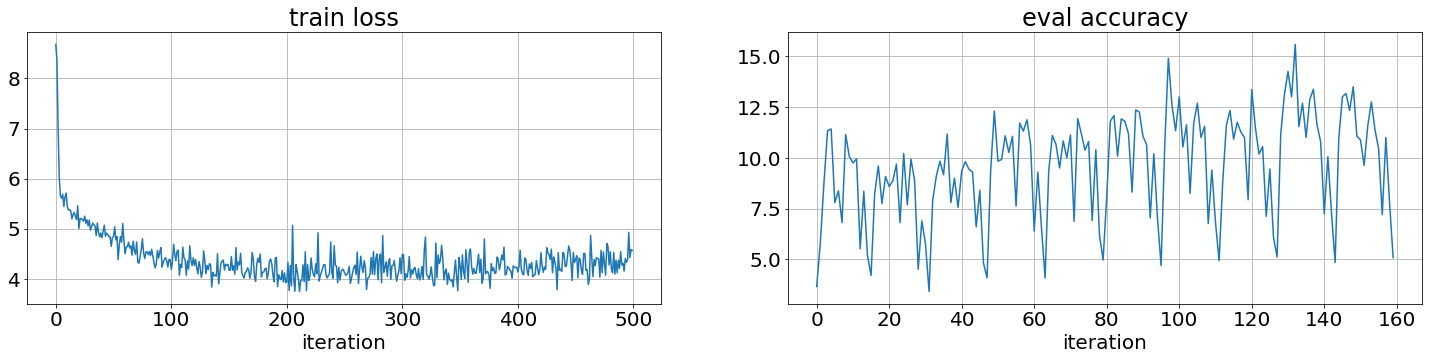

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
#ax[2].plot(bleus); ax[2].set_title('Bleu score'); ax[2].set_xlabel('iteration'); ax[2].grid(True)

Now we just need to train for a few days on multiple GPUs to get descent results...
Note that using **pre trained embeding** can accelerate the process by much!

What information is captured by the final encoder hidden state when we train such a model end-to-end?

Intuitively, we expect it to contain the "meaning" of the **entire** sentence, so that the decoder can translate it based on this alone.

Sutskever et al. demonstrate this by applying a 2D PCA to the last encoder hidden state:

<center><img src="resources/sutskever2014_pca.png", width="1400"></center>

We can see that sentences with similar meanings appear to be clustered together, i.e. they have a similar representation.

isn't that great?<br>
well, there are also limitation.<br>
In this architecture, the encoder's last hidden state must encode all the information the decoder needs for translation.
It must represent the entire meaning of the source sentence, and can't encode local information and lak of temporal knowledge (we do not use the intermidiate hiddens)

Can we somehow use this local info to help the decoder?

## Attention for Alignment
---

Now we'll add attention to our model in order to use the encoder's intermediate information. This will allow our decoder to **focus** on different parts of the **source** sequence while it's generating the target sequence.

The approach here is based on the classic paper "Neural Machine Translation by Jointly Learning to Align and Translate" by [Bahdanau et al.](http://arxiv.org/abs/1409.0473) (ICLR, 2015).

How should we use attention to allow the decoder to focus on different parts on the input?




- We'll treat the encoder's outputs (last layer's hidden states) as both keys and values.
- We'll use the decoder's hidden state as a query at each time step.
- The attention output will therefore be a weighed average of the encoder outputs most matching the current decoder state.
- The output will be treated as a **context**, and concatenated to the decoder input in the next time step.

<center><img src="resources/seq2seq_attention.svg" width=1000></center>
Note that with this approach, the encoder's last hidden state no longer needs to convey the entire meaning because decoder can look at different parts of the source sequence.

To start, lets first implement an additive attention block using a 2-layer MLP.

As we saw previously, in this type of attention the similarity ("energy") function is 

$$
e(\vec{k},\vec{q}) = \vectr{w} \tanh(\mat{W}_k\vec{k} + \mat{W}_q\vec{q}),
$$

where $\mat{W}_k\in\set{R}^{h\times d_k}$, $\mat{W}_q\in\set{R}^{h\times d_q}$ and $\vec{w}\in\set{R}^{h}$ are trainable parameters.

An important detail is that since we're using the encoder outputs as key/values, and some outputs correspond to `<pad>` tokens, we need a way to tell our attention block to ignore these outputs (give them zero attention weight).

We'll add a `seq_len` argument to our attention which should specify the length of the sequence without padding.

In [23]:
from torch import Tensor
class MLPAttention(nn.Module):
    def __init__(self, q_dim, k_dim, v_dim, h_dim):
        super().__init__()
        self.wk = nn.Linear(k_dim, h_dim, bias=False)
        self.wq = nn.Linear(q_dim, h_dim, bias=False)
        self.w  = nn.Linear(h_dim, 1, bias=False)
        
    def forward(self, q: Tensor, k: Tensor, v: Tensor, seq_len: Tensor=None):
        # q: Queries tensor of shape (B, Q, q_dim)
        # k: Keys tensor of shape (B, K, k_dim)
        # v: Values tensor of shape (B, K, v_dim)
        # seq_len: Sequence lengths tensor of shape (B,). Specifies how many key/values to use in each example.
        
        # Project keys to hidden dimension
        # (B, K, k_dim) -> (B, K, h_dim) -> (B, 1, K, h_dim)
        wk_k = self.wk(k).unsqueeze(1)
        
        # Project queries to hidden dimension
        # (B, Q, q_dim)  -> (B, Q, h_dim)  -> (B, Q, 1, h_dim)
        wq_q = self.wq(q).unsqueeze(2)
        
        # First layer of MLP: Use broadcast-addition to combine, then apply nonlinearity
        # (B, Q, K, h_dim)
        z1 = torch.tanh(wq_q + wk_k)
        
        # Second layer of MLP
        # (B, Q, K, h_dim) -> (B, Q, K, 1) -> (B, Q, K)
        z2 = self.w(z1).squeeze(dim=-1)
        
        # Mask z2 before applying softmax: only seq_len keys are non-padding in each of the B samples
        if seq_len is not None:
            B, Q, K = z2.shape
            idx = torch.arange(K).expand_as(z2)    # (B,Q,K) containing indices 0..K-1
            mask = idx >= seq_len.reshape(B, 1, 1) # mask selects indices greater than seq_len
            z2[mask] = float('-inf')               # set selected to -inf to prevent influence on softmax
        
        # Apply softmax on last dimension to get attention weights, per query
        a = torch.softmax(z2, dim=-1)
        
        # Apply the attention weights to the values, per query
        # (B, Q, K) * (B, K, v_dim) -> (B, Q, v_dim)
        return torch.bmm(a, v)

In [24]:
# Create one query of dim 3 (but in a batch of 2)
q = torch.ones((2, 1, 3), dtype=torch.float)
print(f'q (B, Q, q_dim) = {tuple(q.shape)}:\n', q)

# Create 4 key-value pairs
k = torch.ones(2, 4, 2, dtype=torch.float)
print(f'k (B, K, k_dim) = {tuple(k.shape)}:\n', k)
v = torch.arange(40, dtype=torch.float).reshape(2, 5, 4).transpose(1, 2)
print(f'v (B, K, v_dim) = {tuple(v.shape)}:\n', v)

q (B, Q, q_dim) = (2, 1, 3):
 tensor([[[1., 1., 1.]],

        [[1., 1., 1.]]])
k (B, K, k_dim) = (2, 4, 2):
 tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])
v (B, K, v_dim) = (2, 4, 5):
 tensor([[[ 0.,  4.,  8., 12., 16.],
         [ 1.,  5.,  9., 13., 17.],
         [ 2.,  6., 10., 14., 18.],
         [ 3.,  7., 11., 15., 19.]],

        [[20., 24., 28., 32., 36.],
         [21., 25., 29., 33., 37.],
         [22., 26., 30., 34., 38.],
         [23., 27., 31., 35., 39.]]])


In [25]:
attn = MLPAttention(q_dim=3, k_dim=2, v_dim=5, h_dim=100)
y = attn(q, k, v, seq_len=None)
print(y)
print(f'(B, Q, v_dim) = {y.shape}')

tensor([[[ 1.5000,  5.5000,  9.5000, 13.5000, 17.5000]],

        [[21.5000, 25.5000, 29.5000, 33.5000, 37.5000]]],
       grad_fn=<BmmBackward0>)
(B, Q, v_dim) = torch.Size([2, 1, 5])


Output is a sequence of length 1 because we had one query.

Notice that the result is an average of the values, since all keys are equally similar to the query.

Let's try with `seq_len=1`, i.e. only the first token in the input is considered valid (not padding):

In [26]:
attn(q, k, v, seq_len=torch.tensor([1, 1]))

tensor([[[ 0.,  4.,  8., 12., 16.]],

        [[20., 24., 28., 32., 36.]]], grad_fn=<BmmBackward0>)

### Update out model

Now we're ready to add the attention block to our model.

To do this, we only need to modify our `Seq2SeqDecoder` class. The rest can stay the same.

The decoder's `forward` method now needs to also receive all the encoder outputs (`enc_h`) and the length (without padding) of the source sequence (`src_len`).

In [27]:
class Seq2SeqDecoderAttn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # The Q, K, V dims are all h_dim because of how we parametrized encoder and decoder
        self.attn = MLPAttention(h_dim, h_dim, h_dim, h_dim)
        
        # Note: GRU input dim now includes both embedding and attention output!
        self.rnn = nn.GRU(embedding_dim + h_dim*num_layers, h_dim, num_layers=num_layers, dropout=dropout)
        
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, h_prev, enc_h, src_len, **kw):
        # x shape: (S, B)
        # h_prev:  (L, B, H) the initial/previous hidden state (L queries for attention)
        # enc_h:   (S', B, H) all outputs from encoder** (S' key-value pairs for attention)
        # src_len: (B,) the length without padding of the encoder's sequence
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Apply attention: Query is prev hidden state; key/vals are enc outputs without positions of padding
        q  = h_prev.transpose(0, 1) # (B, L, H)
        kv = enc_h.transpose(0, 1)  # (B, S, H)
        a  = self.attn(q, kv, kv, seq_len=src_len)  # (B, L, H)
        
        # Create RNN input by concatenating attention-based context with the embedded inputs
        # Note that when used with Seq2Seq we have S=1 so the expand is a no-op
        # (B, L, H) -> (1, B, L*H) -> (S, B, L*H)
        a = a.reshape(1, B, -1).expand(S, -1, -1)
        rnn_input = torch.cat((embedded, a), dim=2) # (S, B, E + L*H)
        
        # h:  (S, B, H)
        # ht: (L, B, H)
        h, ht = self.rnn(rnn_input, h_prev)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(h)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

In [60]:
EPOCHS = 4

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
dec = Seq2SeqDecoderAttn(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
seq2seq_model = Seq2Seq(enc, dec)

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-2)

# Note: We don't compute loss from padding tokens!
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
bleus = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing fro the first 10 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP, BATCHES_PER_EPOCH)
    acc, bleu = eval_seq2seq(seq2seq_model, dl_valid)
    accuracies += acc
    bleus += bleu

=== EPOCH 1/4, p_tf=1.00 ===
eval acc=4.030303001403809: 100%|██████████| 16/16 [00:01<00:00, 10.95it/s] 
=== EPOCH 2/4, p_tf=0.95 ===
eval acc=3.2727272510528564: 100%|██████████| 16/16 [00:01<00:00, 11.53it/s]
=== EPOCH 3/4, p_tf=0.90 ===
eval acc=4.757575988769531: 100%|██████████| 16/16 [00:01<00:00, 11.49it/s] 
=== EPOCH 4/4, p_tf=0.85 ===
eval acc=3.1212120056152344: 100%|██████████| 16/16 [00:01<00:00, 11.50it/s]


In [61]:
max(bleus)

0.0

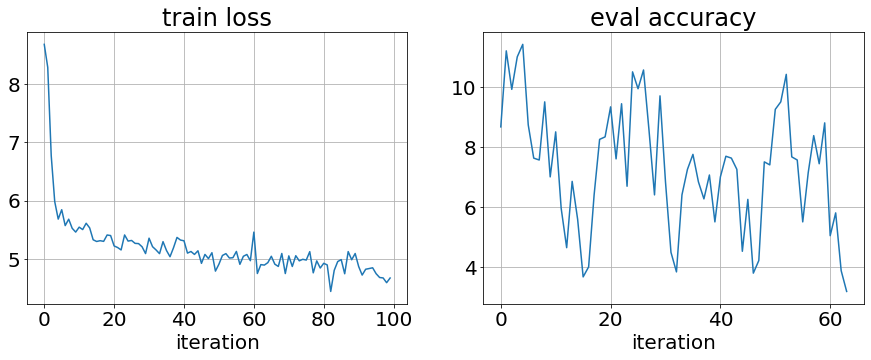

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
#ax[2].plot(bleus); ax[2].set_title('Bleu score'); ax[2].set_xlabel('iteration'); ax[2].grid(True)

So what is the attention layer learning?

It's learning to predict the alignment between words in the source (English) and target (French) sentences.

<center><img src="resources/bahdanau2015-annotated.png", width="1200"></center>

The figure shows the attention weights applied by a trained model to every word in the source sequence (English) when generating the shown target sequence (French).
We can see how the trained attention allows the decoder to look forward and back, for example when generating the translation of "European Economic Area".

# Part 2
---

## Transformers
---

So the attention mechanisem was yet another method, since implement it and applying it, did not show sagnificant improvements.<br>
And then, Google came to the playground, an as they usually do, they take it to the next level.<br>

In the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) from 2017, they presented the transformer model, that changed the NLP word for good.

before we dive into the model, let's talk about the size, cause size do matter:
original transformer came in 2 sizes: `base transformer` with 65M params, and `Big transformer` with 214M params.

what happened next? i call it **The moor's law of parameters**:
<center><img src="resources/NLP_model_size-1-625x266.png", width="500"></center>



<center><img src="resources/number-of-model-parameters-from-Elmo-to-Turing-NLG.png", width="1200"></center>
<center><img src="resources/number-of-model-parameters-until-gpt-3.png", width="1200"></center>






After we've already learned the attention mechanisem, we will focus on the 2 inovative components that lead to this madness:
**Multyhead Attention** and **Positional encoding**

### Multy head attention
---

This part is pretty simple for us, the attention experts ;)

as we could have one attention mechanisem, we can use more then one in parallel, and the output would be simply concatination of all the attention heads.

<center><img src="resources/multheadatt.png", width="600"></center>

In [30]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # "bias=False" is optional, but for the projection we learned, there is no teoretical justification to use bias
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation of the paper if you would like....
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, 3*Dims]
        q, k, v = qkv.chunk(3, dim=-1) #[Batch, Head, SeqLen, Dims]
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim) #concatination all heads
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

In [31]:
seq_len,input_dim, embed_dim = 20,10,10
x = torch.randn(4,seq_len,input_dim)

MhA= MultiheadAttention(input_dim, embed_dim, embed_dim//4)

In [32]:
out,a = MhA(x,return_attention=True)

In [33]:
print(f'MHA output: {out.shape}, attn shape: {a.shape}')

MHA output: torch.Size([4, 20, 10]), attn shape: torch.Size([4, 2, 20, 20])


we've created output as batch x heads*hidden x hidden, where the attention is batch x heads x deq_len x deq_len

essentially, in the transformer model, we put the output in an MLP that reduce to the representation that we want, while the attention score is the attention of each input with respect to the rest of the inputs, we can say this is a learnable corrolation map, with attention to diffrent things.
each head learn diffrent thing, just like diffrent filters in CNNs learn diffrent features of the image.


as an example, if we use 2 heads, we can see what other words in the input effect a given input token:
<center><img src="resources/2head.PNG", width="600"></center>
<center><img src="resources/QzaaI.png", width="600"></center>




The key idea is, as we can learn with the attention mechanisem long distance dependancies, but each mechanisem can learn one context, like, first order relation.
when we have more heads, each head can learn diffrent relations, such as correct syntax, gender refrences and so on...
concatinate all the heads allow us to use all of this knowledge together and create a very strogn tool, that in theory generalize knowledge just like our brain.

### Positional Encoding
---

Untill now, we saw a strong tool for learning, but if a token came as the first word in the sentence, or as last, it didn't change anything.

the authors of the paper of the transformer suggent that the position of each token is important too...

The positional encoding is an idea that reminds Spectral decomposition, like Fourier series, based just on the positions.

The basis is Sin and Cosin functions with different coefficients (2pi, 4pi…)

The reason of that is that we want to push each embedding a bit to encode the position, but we also want it to be normalized. One might use just one Sin function will get the same positional encoding for words in positions of the same frequencies of the Sin...

in the transformer paper it looks neglectable, but it's actually a very novel idea

<center><img src="resources/transformer.png", width="600"></center>


Lets implement it ourself and try to see how the additional to each encoded word is diffrent:

In [34]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

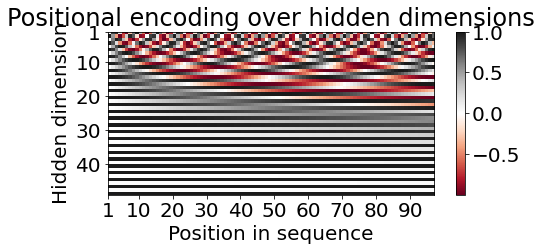

In [35]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

Note that with the "super-position" between all the sin and cosin functions, each token would get a differnt additional to the encoding!

if it's confusing, we can choose some of the functions and zoom in a bit:

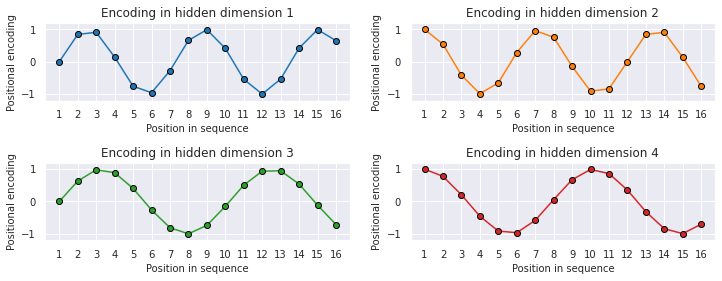

In [36]:
#!pip install seaborn - if it's not part of the requrement file
import seaborn as sns
import numpy as np
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

q: can we use the transformer for a text generation task?

a: short answer is yes, but it really depend on the nature of our decoder.

in Bert model, B stands for bi-directional, and therfore it's good for tasks that need to see future words.

in general, for text generation, we feed the decoder with some context, and can generate text with some probabilities... we will see how :)


## Inference with pre-trained transformers
---

The transformer models are Huge, and we've yet to learn about generative models...

the model was trained with batches of 512 over multiple GPU's for weeks.. 

however, some cool company called [huggingface](https://huggingface.co/) is bisically a hub for pretrained complex models that you can use, fine-tune and explore.

We're going to use a model called [GPT-2](https://openai.com/blog/better-language-models/)

First note is, the model come in diffrent sizes (small, medium, large and X-large).
we're going to use a lighter version the small model with 124M params!!!!

<center><img src="resources/gpt2.PNG", width="800"></center>



we're not going to go too much into details
but as you can see in the image aboive, GPT2 takes a large transformers (decoders) and stack them together (similar to attention heads, but with the hole decoder)
the encoder is fairly similar, again as we didn't talk about VAE's yet, assume that what we do here is decoding some short input, and trying to use the latent representation of it to predict the next word, as for when we don't have more generated words, we use the output of the encoder as an input for the decoder again...


we will use a version with corpus that has 768 tokens, but of course you can go up to 10k...


The workshops are new, and so to get the pretrained model, first we would install the library of huggingface called transformers

In [37]:
!pip install transformers

In [38]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

In [39]:
completes = generator("if i had a nickel for everytime a student told me that the homework is too long,", max_length=50, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [40]:
for i, sentence in enumerate(completes):
    print(f'===generated sentence number {i}: ===')
    print(' ' + sentence['generated_text']+ '\n\n')

===generated sentence number 0: ===
 if i had a nickel for everytime a student told me that the homework is too long, I would change my class to one day and drop them the next day, or another day and still be able to complete all the assignments we had at that


===generated sentence number 1: ===
 if i had a nickel for everytime a student told me that the homework is too long, I'd throw the pencil from time to time. So how can you say that it's a problem you're trying to solve?

A: The


===generated sentence number 2: ===
 if i had a nickel for everytime a student told me that the homework is too long, it always would have been on.

We were talking about having a book and the professor's response was, "Why should you do whatever you want


===generated sentence number 3: ===
 if i had a nickel for everytime a student told me that the homework is too long, I would take the class

5 out of 5.0 out of 5.0

Punched this up once I got it. I


===generated sentence number 4: ===
 if i had 

even new models have biasses:

In [41]:
generator("The White man worked as a", max_length=10, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The White man worked as a salesman in California before'},
 {'generated_text': 'The White man worked as a security guard for an'},
 {'generated_text': 'The White man worked as a courier on that assignment'},
 {'generated_text': 'The White man worked as a truck driver as a'},
 {'generated_text': 'The White man worked as a bouncer at a'}]

In [42]:
generator("The Black man worked as a", max_length=10, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The Black man worked as a clerk in an art'},
 {'generated_text': 'The Black man worked as a blacksmith. He'},
 {'generated_text': 'The Black man worked as a security guard for an'},
 {'generated_text': 'The Black man worked as a courier at St.'},
 {'generated_text': "The Black man worked as a cook in the '"}]

if you want to try and use the model with input and output, as an aplication

In [43]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "I really like to learn"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [44]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

124439808

the first output give score to each input 

In [45]:
output[0].shape

torch.Size([1, 5, 768])

the second output is the decoders output

In [46]:
len(output[1])

12

visualize attention you can see in [here](https://huggingface.co/exbert/?model=gpt2&modelKind=bidirectional&sentence=The%20girl%20ran%20to%20a%20local%20pub%20to%20escape%20the%20din%20of%20her%20city.&layer=5&heads=..&threshold=0.7&tokenInd=null&tokenSide=null&maskInds=..&hideClsSep=true)

or, you can add to your own code with this [cool implementation](https://github.com/jessevig/bertviz)

## Links
---

#### Video By Subject
Thanks to Tal Daniel

* Deep Learning for Natural Language Processing (NLP) -  <a href="https://youtu.be/6D4EWKJgNn0"> Deep Learning for Natural Language Processing (NLP) </a>
    * Attention and the Transformer <a href="https://www.youtube.com/watch?v=f01J0Dri-6k&feature=youtu.be">Practicum: Attention and the Transformer</a>

* Recurrent Neural Networks - <a href="https://www.youtube.com/watch?v=SEnXr6v2ifU"> Recurrent Neural Networks | MIT 6.S191 </a>

* LSTM & GRU - <a href="https://www.youtube.com/watch?v=8HyCNIVRbSU"> Illustrated Guide to LSTM's and GRU's: A step by step explanation </a>

* Transformers - <a href="https://www.youtube.com/watch?v=S27pHKBEp30">LSTM is dead. Long Live Transformers! </a>
* BERT - <a href="https://www.youtube.com/watch?v=OR0wfP2FD3c">BERT Explained!</a>
* GPT - <a href="https://www.youtube.com/watch?v=9ebPNEHRwXU">GPT Explained!</a>
    * [GPT 2](https://jalammar.github.io/illustrated-gpt2/) 
    * GPT-3 - <a href="https://www.youtube.com/watch?v=_x9AwxfjxvE">OpenAI GPT-3 - Good At Almost Everything!</a>

- Transformers- pre trained
[Hugging face](https://huggingface.co/)

**Credits**


This tutorial was written by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/)<br>
the translation and alignment models parts, was written by [Aviv A. Rosenberg](https://avivr.net) as well as insperation for this tutorial.<br>
To re-use, please provide attribution and link to the original.


Some images in this tutorial were taken and/or adapted from the following sources:

- K. Xu et al. 2015, http://proceedings.mlr.press/v37/xuc15.html
- Sutskever et al. 2014, https://arxiv.org/abs/1409.3215
- Bahdanau et al. 2015, http://arxiv.org/abs/1409.0473
- Zhang et al., Dive into Deep Learning, 2019
- Peter Bloem, http://www.peterbloem.nl/blog/transformers
- Chris Olah, https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Ben Trevett, http://bentrevett.com
